<a href="https://colab.research.google.com/github/aquangnguyen1992/Advanced_Data_Science_Capstone/blob/master/Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Get the dataset from Kaggle***

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"
!kaggle competitions download -c ieee-fraud-detection
!unzip \*.zip  && rm *.zip

  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 110MB/s]
  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 76.9MB/s]
 93% 54.0M/58.3M [00:02<00:00, 17.1MB/s]
100% 58.3M/58.3M [00:02<00:00, 24.3MB/s]
 79% 41.0M/52.2M [00:01<00:00, 21.3MB/s]
100% 52.2M/52.2M [00:01<00:00, 40.0MB/s]
Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   

Archive:  test_identity.csv.zip
  inflating: test_identity.csv       

Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   

Archive:  test_transaction.csv.zip
  inflating: test_transaction.csv    

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      

5 archives were successfully processed.


# ***Analyzing the dataset and doing the cleansing***

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import copy
import os
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
os.chdir("/content")
dataset_transaction = pd.read_csv('train_transaction.csv')
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
dataset_identity = pd.read_csv('train_identity.csv')
dataset_identity.head(5)

,TransactionID,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
1,2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,100.0,NotFound,49.0,-300.0,New,NotFound,166.0,NaN,621.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,iOS 11.1.2,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2,2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,52.0,NaN,Found,Found,121.0,NaN,410.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
3,2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,100.0,NotFound,52.0,NaN,New,NotFound,225.0,NaN,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
4,2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,100.0,NotFound,NaN,-300.0,Found,Found,166.0,15.0,529.0,575.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Found,Found,Mac OS X 10_11_6,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


In [6]:
dataset_identity.columns

Index(['TransactionID', 'id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object')

In [7]:
dataset_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=394)

**Check NaN, Null, and OneHotEncoding**

In [6]:
float_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = dataset_transaction.columns[np.where(dataset_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']

In [7]:
def normalization_data(X, indices):
  X_out = copy.copy(X)
  X_temp = X[indices]
  X_out.iloc[indices] = (X_temp-np.mean(X_temp))/(np.max(X_temp)-np.min(X_temp))
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0
  return np.min(X_temp), np.max(X_temp), np.mean(X_temp), X_out.astype('float16')

In [8]:
data_backup = copy.copy(dataset_transaction)
data_backup.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321,V322,V323,V324,V325,V326,V327,V328,V329,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Task 1: Detect the columns with NaN and code it with an extra features
# Task 2: Apply normalizationn
# Task 3: Remove the irrelevant columns

cache = dict()
dataset_transaction = copy.copy(data_backup)

#dataset_transaction.pop()

for column in float_columns:
  # Set to float 16
  dataset_transaction[column].astype('float16')

  # Code the NaN feature
  if np.any(np.isnan(dataset_transaction[column].values)):
    dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [10]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300_NaN_Code,V301_NaN_Code,V302_NaN_Code,V303_NaN_Code,V304_NaN_Code,V305_NaN_Code,V306_NaN_Code,V307_NaN_Code,V308_NaN_Code,V309_NaN_Code,V310_NaN_Code,V311_NaN_Code,V312_NaN_Code,V313_NaN_Code,V314_NaN_Code,V315_NaN_Code,V316_NaN_Code,V317_NaN_Code,V318_NaN_Code,V319_NaN_Code,V320_NaN_Code,V321_NaN_Code,V322_NaN_Code,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,86400,-0.002083,W,13926,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,0.0,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,86401,-0.003321,W,2755,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,86469,-0.002380,W,4663,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,0.0,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,86499,-0.002663,W,18132,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,0.0,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,86506,-0.002663,H,4497,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
for column in int_columns:
  # Set to int 32
  dataset_transaction[column].astype('int32')

  # Code the NaN feature
  if np.any(np.isnan(dataset_transaction[column].values)):
    dataset_transaction[column + "_NaN_Code"] = np.isnan(dataset_transaction[column].values).astype('int8')
  
  # Normalization
  X = dataset_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'], dataset_transaction[column] = normalization_data(X, indices)

In [12]:
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,V300_NaN_Code,V301_NaN_Code,V302_NaN_Code,V303_NaN_Code,V304_NaN_Code,V305_NaN_Code,V306_NaN_Code,V307_NaN_Code,V308_NaN_Code,V309_NaN_Code,V310_NaN_Code,V311_NaN_Code,V312_NaN_Code,V313_NaN_Code,V314_NaN_Code,V315_NaN_Code,V316_NaN_Code,V317_NaN_Code,V318_NaN_Code,V319_NaN_Code,V320_NaN_Code,V321_NaN_Code,V322_NaN_Code,V323_NaN_Code,V324_NaN_Code,V325_NaN_Code,V326_NaN_Code,V327_NaN_Code,V328_NaN_Code,V329_NaN_Code,V330_NaN_Code,V331_NaN_Code,V332_NaN_Code,V333_NaN_Code,V334_NaN_Code,V335_NaN_Code,V336_NaN_Code,V337_NaN_Code,V338_NaN_Code,V339_NaN_Code
0,2987000,0,-0.463379,-0.002083,W,0.231445,0.000000,-0.024384,discover,-0.418213,credit,0.055145,0.002167,-0.009674,0.0,NaN,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1,2987001,0,-0.463379,-0.003321,W,-0.410645,0.082886,-0.024384,mastercard,-0.709961,credit,0.077881,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,2987002,0,-0.463379,-0.002380,W,-0.301025,0.254883,-0.024384,visa,-0.242920,debit,0.089233,0.002167,0.016388,0.0,outlook.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
3,2987003,0,-0.463379,-0.002663,W,0.473389,0.408936,-0.024384,mastercard,-0.600586,debit,0.421143,0.002167,0.000000,0.0,yahoo.com,NaN,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,2987004,0,-0.463379,-0.002663,H,-0.310547,0.302979,-0.024384,mastercard,-0.709961,credit,0.293701,0.002167,0.000000,0.0,gmail.com,NaN,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [13]:
from sklearn.preprocessing import OneHotEncoder
for column in obj_columns:
  ohc = OneHotEncoder()
  dataset_transaction.loc[np.where(dataset_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(dataset_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(dataset_transaction[column].astype('str'))))])
  dataset_transaction = pd.concat([dataset_transaction, pd_encoded], axis=1)

for column in obj_columns:
  try:
    dataset_transaction.pop(column)
  except KeyError:
    pass
dataset_transaction.head(5)

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,...,R_emaildomain_49,R_emaildomain_50,R_emaildomain_51,R_emaildomain_52,R_emaildomain_53,R_emaildomain_54,R_emaildomain_55,R_emaildomain_56,R_emaildomain_57,R_emaildomain_58,R_emaildomain_59,R_emaildomain_60,M1_0,M1_1,M1_2,M2_0,M2_1,M2_2,M3_0,M3_1,M3_2,M4_0,M4_1,M4_2,M4_3,M5_0,M5_1,M5_2,M6_0,M6_1,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,2987000,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.126709,-0.184814,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
1,2987001,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
2,2987002,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.232910,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,2987003,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,0.0,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,-0.045654,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0
4,2987004,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [14]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

False False


**Apply Seaborn to preliminary analyze the dataset**

In [15]:
colums_to_analyze = ['isFraud', 'TransactionDT', 'TransactionAmt', 'P_emaildomain_0', 'P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3', 'P_emaildomain_4', 'addr1', 'addr2', 'dist1', 'dist2']
analyzing_data = dataset_transaction[colums_to_analyze]

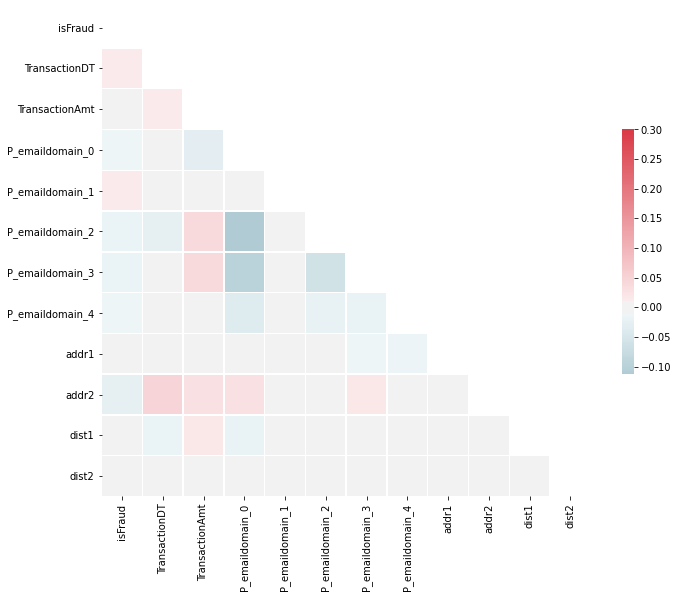

In [16]:
corr = analyzing_data.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# ***Creat the train/val dataset***

In [17]:
# Create a copy
dataset = copy.copy(dataset_transaction)

# Remove the irrelevant columns
dataset.pop('TransactionID')
dataset.head(5)

,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,...,R_emaildomain_49,R_emaildomain_50,R_emaildomain_51,R_emaildomain_52,R_emaildomain_53,R_emaildomain_54,R_emaildomain_55,R_emaildomain_56,R_emaildomain_57,R_emaildomain_58,R_emaildomain_59,R_emaildomain_60,M1_0,M1_1,M1_2,M2_0,M2_1,M2_2,M3_0,M3_1,M3_2,M4_0,M4_1,M4_2,M4_3,M5_0,M5_1,M5_2,M6_0,M6_1,M6_2,M7_0,M7_1,M7_2,M8_0,M8_1,M8_2,M9_0,M9_1,M9_2
0,0,-0.463379,-0.002083,0.231445,0.000000,-0.024384,-0.418213,0.055145,0.002167,-0.009674,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002584,-0.001279,-0.010811,-0.005104,-0.125488,0.000000,-0.018738,0.000000,0.000000,0.0,0.0,0.0,0.0,-0.126709,-0.184814,0.0,0.0,0.0,-0.170166,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0
1,0,-0.463379,-0.003321,-0.410645,0.082886,-0.024384,-0.709961,0.077881,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.021332,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.000000,0.0,0.0,0.0,-0.170166,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
2,0,-0.463379,-0.002380,-0.301025,0.254883,-0.024384,-0.242920,0.089233,0.002167,0.016388,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,-0.141235,0.000000,0.0,0.0,0.0,0.0,-0.141479,0.232910,0.0,0.0,0.0,0.157227,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0
3,0,-0.463379,-0.002663,0.473389,0.408936,-0.024384,-0.600586,0.421143,0.002167,0.000000,0.0,-0.002581,-0.001804,-0.000217,-0.001817,-0.015961,-0.002251,-0.001264,-0.001544,-0.016571,-0.001609,-0.002899,-0.001279,-0.002584,-0.005104,0.027588,-0.089966,-0.034607,-0.046417,-0.051697,0.0,0.0,0.0,0.0,-0.045654,0.000000,0.0,0.0,0.0,-0.054840,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,1,0
4,0,-0.463379,-0.002663,-0.310547,0.302979,-0.024384,-0.709961,0.293701,0.002167,0.000000,0.0,-0.002794,-0.002508,-0.000217,-0.001817,-0.015961,-0.003582,-0.001264,-0.001245,-0.021332,-0.001302,-0.002899,-0.001279,-0.010811,-0.005104,-0.147461,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0


In [18]:
from sklearn.model_selection import train_test_split

Y = dataset['isFraud']
dataset.pop('isFraud')
X = dataset

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

print(X_train.shape, Y_train.shape, X_test.shape)

(472432, 903) (472432,) (118108, 903)


Percentage of Fraud: 3.51%


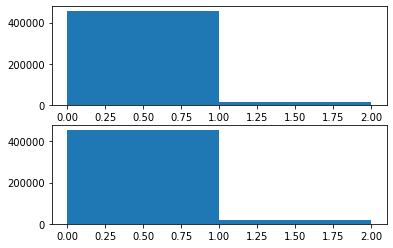

In [19]:
plt.subplot(211)
plt.hist(Y_train, bins=[0,1,2])

plt.subplot(212)
plt.hist(Y_train, bins=[0,1,2])

fraud_count = np.unique(Y_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

**Downsampling and upsampling**

In [20]:
downsampling_factor = 1
indices_1 = np.argwhere(np.array(Y_train)==1)
indices_0_new = np.argwhere(np.array(Y_train)==0)
indices = np.arange(0,len(indices_0_new),downsampling_factor)
indices_0_new = indices_0_new[indices]

print(indices_0_new.shape)

upsampling_factor = 10
indices_1_new = indices_1
for i in range(upsampling_factor):
  indices_1_new = np.concatenate((indices_1_new, indices_1), axis=0)

indices_0_new = np.concatenate((indices_1_new, indices_0_new), axis=0)

print(indices_0_new.shape)

indices_0_new = tf.random.shuffle(indices_0_new)

X_to_train = np.array(X_train)[indices_0_new]
Y_to_train = np.array(Y_train)[indices_0_new]


X_to_train = np.reshape(X_to_train, (X_to_train.shape[0], X_to_train.shape[2]))
Y_to_train = np.squeeze(Y_to_train, axis=1)
print(X_to_train.shape, Y_to_train.shape)

(455864, 1)
(638112, 1)
(638112, 903) (638112,)


**Check the imbalane of the train/test dataset**

Percentage of Fraud: 28.56%


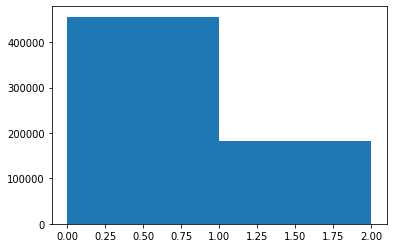

In [21]:
plt.hist(Y_to_train, bins=[0,1,2])

fraud_count = np.unique(Y_to_train, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_count[1][1]/np.sum(fraud_count[1])*100,2)) + "%")

# ***The model using NN***

In [22]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score

In [36]:
def create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0.001, l2_rate=0.001, init_std=0.01, lr=0.001):
  out_model = Sequential()
  out_model.add(Dense(dense1, activation="relu", input_shape=(X_train.shape[1],),
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense1, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(dense2, activation="relu", 
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dense(dense2, activation="relu",
                      kernel_regularizer=tf.keras.regularizers.l1(l1_rate),
                      kernel_initializer=tf.keras.initializers.RandomUniform(minval=-init_std, maxval=init_std),
                      activity_regularizer=tf.keras.regularizers.l2(l2_rate)))
  out_model.add(Dropout(dropout_rate))
  out_model.add(BatchNormalization())

  out_model.add(Dense(1, activation="sigmoid"))

  out_model.compile(
            optimizer=Adam(learning_rate=lr),
            loss='binary_crossentropy',
            metrics=[tfa.metrics.F1Score(num_classes=2, average="micro", threshold=0.9)])
  
  return out_model

In [37]:
my_model = create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=5e-5, l2_rate=5e-4, init_std=0.05, lr=0.00001)
my_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               115712    
_________________________________________________________________
dense_16 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 128)               512       
_________________________________________________________________
dense_17 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_18 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [38]:
BATCH_SIZE = 256
NB_EPOCH = 2000

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_f1_score', patience=200, verbose=0, mode='max',
    baseline=None)

best_model_hold = tf.keras.callbacks.ModelCheckpoint(
    filepath='/content/best_model', monitor='val_f1_score', verbose=1, save_best_only=True,
    save_weights_only=True, mode='max')

history = my_model.fit(X_to_train, Y_to_train, 
             batch_size=BATCH_SIZE, epochs=NB_EPOCH,
             validation_split=0.2, shuffle=True,
             callbacks=[early_stop, best_model_hold])

Epoch 1/2000
1988/1995 [============================>.] - ETA: 0s - loss: 0.7572 - f1_score: 0.2588
Epoch 00001: val_f1_score improved from -inf to 0.42002, saving model to /content/best_model
1995/1995 [==============================] - 13s 7ms/step - loss: 0.7570 - f1_score: 0.2592 - val_loss: 0.6346 - val_f1_score: 0.4200
Epoch 2/2000
1990/1995 [============================>.] - ETA: 0s - loss: 0.6096 - f1_score: 0.4152
Epoch 00002: val_f1_score improved from 0.42002 to 0.43098, saving model to /content/best_model
1995/1995 [==============================] - 13s 7ms/step - loss: 0.6096 - f1_score: 0.4152 - val_loss: 0.5605 - val_f1_score: 0.4310
Epoch 3/2000
1995/1995 [==============================] - ETA: 0s - loss: 0.5604 - f1_score: 0.4385
Epoch 00003: val_f1_score improved from 0.43098 to 0.44391, saving model to /content/best_model
1995/1995 [==============================] - 13s 6ms/step - loss: 0.5604 - f1_score: 0.4385 - val_loss: 0.5294 - val_f1_score: 0.4439
Epoch 4/2000


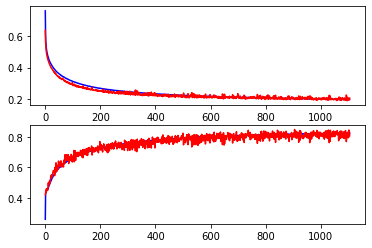

In [39]:
plt.subplot(211)
plt.plot(history.history["loss"], '-b')
plt.plot(history.history["val_loss"], '-r')

plt.subplot(212)
plt.plot(history.history["f1_score"], '-b')
plt.plot(history.history["val_f1_score"], '-r')



**F1 validation (From https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model)**

In [40]:
# Save model weights to drive
!cp best_model* '/content/gdrive/My Drive/Kaggle'

new_model = create_model(dense1=128, dense2=64, dropout_rate=0.4, l1_rate=0, l2_rate=0, init_std=0.05, lr=0.00005)
new_model.load_weights('/content/best_model')

new_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               115712    
_________________________________________________________________
dense_21 (Dense)             (None, 128)               16512     
_________________________________________________________________
dropout_8 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 128)               512       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_9 (Dropout)          (None, 64)               

In [29]:
from sklearn.metrics import classification_report

def precision_cal(y_pred, y_ref):
  pre = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    if true_pos == len(indices_positive):
      false_pos = 0
    else:
      false_pos = len(indices_positive) - true_pos

    pre = true_pos/(true_pos + false_pos)
  return pre

def recall_cal(y_pred, y_ref):
  recall = 0
  if np.any(y_pred == 1):
    indices_positive = np.argwhere(y_pred == 1)
    true_pos = np.sum(y_ref[indices_positive])

    fals_neg = np.sum(y_ref[np.argwhere(y_pred == 0)])
       
    recall = true_pos/(true_pos + fals_neg)

  return recall

def F1_score(model, X_test, y_ref, test_size, threshold=0.5):
  test_size = len(Y_test)
  y_pred = (model.predict(X_test[:test_size], batch_size=128)>threshold).astype(int)
  y_pred = np.squeeze(y_pred, axis=1)
  y_pred[7] = 1
  y_pred[23] = 1
  #pred_dist = np.unique(y_pred.astype(int), return_counts=True)
  #correct_prediction = np.unique(y_pred == np.expand_dims(Y_test[:test_size], axis=1), return_counts=True)
  #print(pred_dist, correct_prediction[0])
  
  precision = precision_cal(y_pred, np.array(Y_test[:test_size]))
  recall = recall_cal(y_pred, np.array(Y_test[:test_size]))

  return precision, recall, 2*precision*recall/(precision+recall)

pre, re, f1 = F1_score(my_model, X_test, Y_test, test_size=12800, threshold=0.9)
print(pre, re, f1)

0.8738296923762817 0.47863247863247865 0.6184916377406122


In [30]:
my_model.evaluate(X_test, Y_test)
prediction = my_model.predict(X_test)

3691/3691 [==============================] - 10s 3ms/step - loss: 0.1055 - f1_score: 0.6187


In [31]:
my_model.evaluate(X_train, Y_train, batch=BATCH_SIZE)

14764/14764 [==============================] - 41s 3ms/step - loss: 0.0445 - f1_score: 0.7743


[0.044480133801698685, 0.7743173241615295]

Percentage of Fraud: 3.61% 3.47%


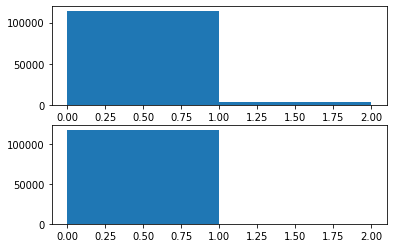

In [32]:
prediction = np.squeeze(prediction, axis=1)

plt.subplot(211)
plt.hist(Y_test, bins=[0,1,2])

plt.subplot(212)
plt.hist(prediction, bins=[0,1,2])



fraud_predict = np.unique((prediction>0.5).astype('int'), return_counts=True)
fraud_real = np.unique(Y_test, return_counts=True)
print("Percentage of Fraud: " + str(round(fraud_predict[1][1]/np.sum(fraud_predict[1])*100,2)) + "% " + str(round(fraud_real[1][1]/np.sum(fraud_real[1])*100,2)) + "%")



In [ ]:
fraud_count

(array([0, 1]), array([65115, 33254]))

# ***Output the result into a file for a validation with Kaggle***

In [ ]:
os.chdir("/content")
test_transaction = pd.read_csv('test_transaction.csv')
test_transaction.head(5)

In [ ]:
float_columns = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('float64'))].to_list()
int_columns = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('int64'))].to_list()
obj_columns = test_transaction.columns[np.where(test_transaction.dtypes == np.dtype('O'))].to_list()

skip_int_columns = ['TransactionID', 'isFraud']
for column in skip_int_columns:
  int_columns.remove(column)

skip_obj_colums = ['']

In [ ]:
def apply_normalization(X, indices, cache_min, cache_max, cache_mean):
  X_out = copy.copy(X)
  X_temp = X[indices]
  X_out.iloc[indices] = (X_temp - cache_mean)/(cache_max - cache_min)
  X_out.iloc[np.where(np.isnan(X_out))[0]] = 0
  return X_out.astype('float16')  


In [ ]:
for column in float_columns:
  # Set to float 16
  test_transaction[column].astype('float16')

  # Code the NaN feature
  if np.any(np.isnan(test_transaction[column].values)):
    test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(test_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X, indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [ ]:
for column in int_columns:
  # Set to int 32
  test_transaction[column].astype('int32')

  # Code the NaN feature
  if np.any(np.isnan(test_transaction[column].values)):
    test_transaction[column + "_NaN_Code"] = np.isnan(test_transaction[column].values).astype('int8')
  
  # Normalization
  X = test_transaction[column]
  indices = np.where(np.isnan(dataset_transaction[column]) == False)[0]
  test_transaction[column] = apply_normalization(X, indices, cache[column+'_min'], cache[column+'_max'], cache[column+'_mean'])

In [ ]:
for column in obj_columns:
  ohc = OneHotEncoder()
  test_transaction.loc[np.where(test_transaction[column].isnull())[0], column] = 'Null'
  encoded = ohc.fit_transform(test_transaction[column].values.reshape(-1,1)).toarray()    
  pd_encoded = pd.DataFrame(encoded.astype('int8'), columns=[column+"_"+str(i) for i in range(len(np.unique(test_transaction[column].astype('str'))))])
  test_transaction = pd.concat([test_transaction, pd_encoded], axis=1)

for column in obj_columns:
  try:
    test_transaction.pop(column)
  except KeyError:
    pass

test_transaction.head(5)

In [ ]:
print(np.any(np.isnan(dataset_transaction)), np.any(dataset_transaction.isnull()))

In [ ]:
print(test_transaction.shape, X_train.shape)

# ***Debug zone***

In [ ]:
indices = np.where(np.isnan(a) == False)[0]
min_value, max_value, mean_value, normalized_data = normalization_data(a, indices)
print(min_value, max_value, mean_value, np.mean(normalized_data), np.min(normalized_data), np.max(normalized_data))
dataset_transaction['V331'] = normalized_data

0.0 160000.0 721.7418829164045 -2.2733716828843707e-16 -0.004510886768227528 0.9954891132317726


**Train val dataset**